In [1]:
# Importing Packages and Libraries
import shap
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.pipeline import Pipeline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# 1. Feature Preperation

In [2]:
# Load data
file_path = '/Users/paulahofmann/Documents/Coding/Online-Review/FeaturePreperation/Data_with_Features/Final Data/Hedonic_Final_Cleaned.csv'
df = pd.read_csv(file_path)

In [3]:
# Create a new column 'helpful' based on reviews being helfpul or not helpful
df['helpful'] = (df['helpful_vote'] > 0).astype(int)

In [4]:
# Define features and target variable
features = ['RewExt','Sentiment','Subjective', 'WordC', 'SentC', 'SentL', 'TitleL', 'ElapDays',
            'Image', 'VerPur', 'NounR', 'AdjR', 'AdvR', 'FRE', 'Prod']
target = 'helpful'


In [5]:
# Define categorical and numerical features
categorical_features = ['Prod']
numerical_features = ['RewExt','Sentiment','Subjective', 'WordC', 'SentC', 'SentL', 'TitleL', 'ElapDays',
            'Image', 'VerPur', 'NounR', 'AdjR', 'AdvR', 'FRE']

# Convert 'product' column to categorical type
df['Prod'] = df['Prod'].astype('category')

# Initialize X and y
X = df[categorical_features+numerical_features]
y = df[target]

# Initialize ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), categorical_features),  # One-hot encode 'product'
        ("num", MinMaxScaler(), numerical_features),     # Scale numerical features
    ]
)

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(X)

# Retrieve column names for the one-hot encoded features
cat_column_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine column names for the transformed features
all_column_names = np.concatenate([cat_column_names, numerical_features])

# Convert the transformed data back to a DataFrame
X = pd.DataFrame(X_preprocessed, columns=all_column_names)

In [6]:
# Define categorical and numerical features
numerical_features = ['RewExt','Sentiment','Subjective', 'WordC', 'SentC', 'SentL', 'TitleL', 'ElapDays',
            'Image', 'VerPur', 'NounR', 'AdjR', 'AdvR', 'FRE']



# Initialize X and y
X = df[numerical_features]
y = df[target]

# Initialize ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        # One-hot encode 'product'
        ("num", MinMaxScaler(), numerical_features),     # Scale numerical features
    ]
)

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(X)

# Retrieve column names for the one-hot encoded features

# Combine column names for the transformed features
all_column_names = np.concatenate([ numerical_features])

# Convert the transformed data back to a DataFrame
X = pd.DataFrame(X_preprocessed, columns=all_column_names)

# 2 Train/Test Split with Stratified K-Fold Cross-validation for Unbalanced Dataset

In [7]:
from sklearn.model_selection import StratifiedKFold

# Create a combined column for stratification
df['stratify'] = df['helpful'].astype(str) + "_" + df['Prod'].astype(str)

# Define StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

stratify = df['stratify']

# Splitting the data
for train_index, test_index in skf.split(X, stratify):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Print the shapes of the resulting splits to check
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)

    # Optionally, you can check the distribution in each split
    print("Train stratify distribution:\n", y_train.value_counts(normalize=True))
    print("Test stratify distribution:\n", y_test.value_counts(normalize=True))

X_train shape: (16610, 14)
X_test shape: (1846, 14)
y_train shape: (16610,)
y_test shape: (1846,)
Train stratify distribution:
 helpful
0    0.831306
1    0.168694
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.830986
1    0.169014
Name: proportion, dtype: float64
X_train shape: (16610, 14)
X_test shape: (1846, 14)
y_train shape: (16610,)
y_test shape: (1846,)
Train stratify distribution:
 helpful
0    0.831246
1    0.168754
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.831528
1    0.168472
Name: proportion, dtype: float64
X_train shape: (16610, 14)
X_test shape: (1846, 14)
y_train shape: (16610,)
y_test shape: (1846,)
Train stratify distribution:
 helpful
0    0.831306
1    0.168694
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.830986
1    0.169014
Name: proportion, dtype: float64
X_train shape: (16610, 14)
X_test shape: (1846, 14)
y_train shape: (16610,)
y_test shape: (1846,)
Train stratify di

## 2.1 Data Augmentation 

In [8]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to X_train and y_train
smote = SMOTE(random_state=42,sampling_strategy={1: 8000})
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


# Check the class distribution before resampling
print("Class distribution before SMOTE:")
print(pd.Series(y_train).value_counts())

# Check the class distribution after resampling
print("Class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())


Class distribution before SMOTE:
helpful
0    13808
1     2803
Name: count, dtype: int64
Class distribution after SMOTE:
helpful
0    13808
1     8000
Name: count, dtype: int64


# 3. Model Building 

## 3.1 Logistic Regression

In [9]:
#Using Logistic Regression
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model
logreg_model = LogisticRegression(solver='sag', max_iter=1000)  # You can adjust max_iter as needed

# Train the model
logreg_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = logreg_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

# Generate classification report
print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

Accuracy: 0.8476964769647697
F1 Score: 0.2739018087855297
AUC: 0.5777122626678461
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      1534
           1       0.70      0.17      0.27       311

    accuracy                           0.85      1845
   macro avg       0.78      0.58      0.59      1845
weighted avg       0.83      0.85      0.81      1845

[[1511   23]
 [ 258   53]]


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification



# Initialize the logistic regression model
RF_model = RandomForestClassifier()  # You can adjust max_iter as needed

# Train the model
RF_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = RF_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

# Generate classification report
print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)



Accuracy: 0.8753387533875339
F1 Score: 0.5147679324894515
AUC: 0.6827777242104999
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1534
           1       0.75      0.39      0.51       311

    accuracy                           0.88      1845
   macro avg       0.82      0.68      0.72      1845
weighted avg       0.86      0.88      0.86      1845

[[1493   41]
 [ 189  122]]


## 3.2 Extreme Gradient Boosting

In [11]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

# Train model with default hyperparameters
xgb_cls_default = xgb.XGBClassifier()

xgb_cls_default.fit(X_train, y_train)

# Predictions on test data
y_pred_default = xgb_cls_default.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_default)
conf_matrix = confusion_matrix(y_test, y_pred_default)
cls_report = classification_report(y_test, y_pred_default)

print("\nDefault Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_default)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_default)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_default, X_train, y_train, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)



Default Model Evaluation:
Accuracy: 0.8682926829268293
F1 Score: 0.5225933202357564
AUC: 0.6926399258815195
Confusion Matrix:
[[1469   65]
 [ 178  133]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1534
           1       0.67      0.43      0.52       311

    accuracy                           0.87      1845
   macro avg       0.78      0.69      0.72      1845
weighted avg       0.85      0.87      0.86      1845

Mean Cross-Validated Accuracy: 0.8526888562249173


## 1.2 Feature Importance with Shap Values

[15:07:05] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


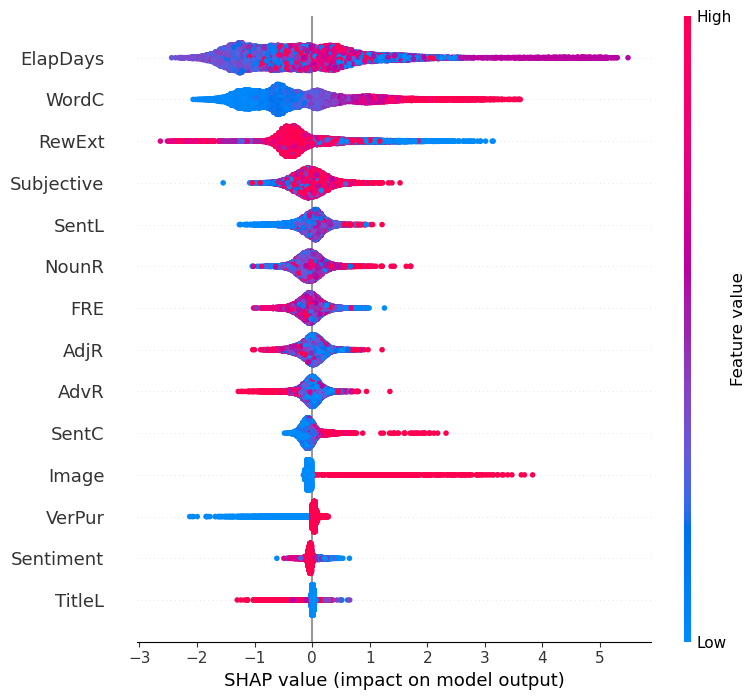

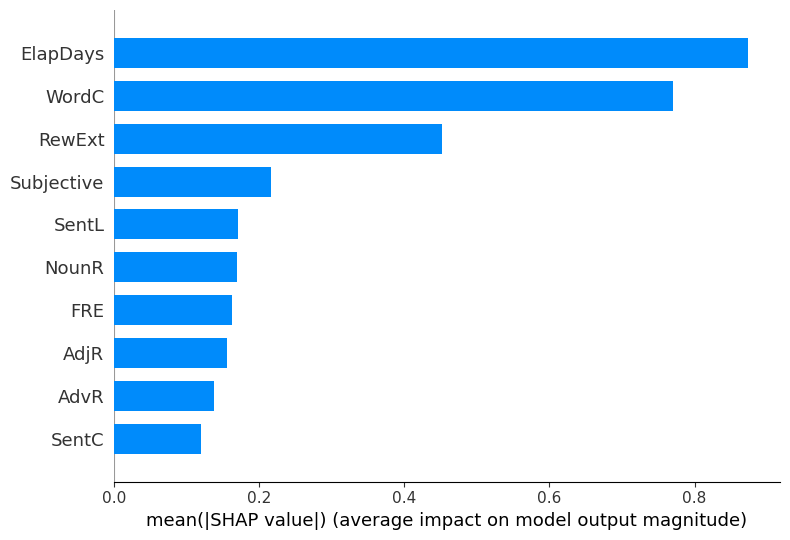

In [12]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_cls_default)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train)

# Create a beeswarm plot
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False, max_display=10)
plt.show()

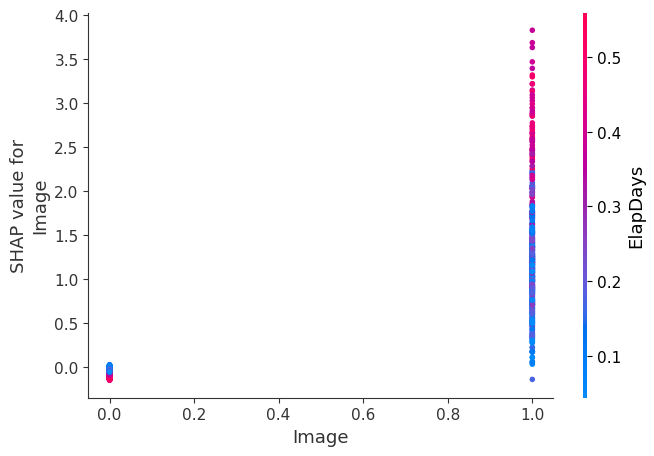

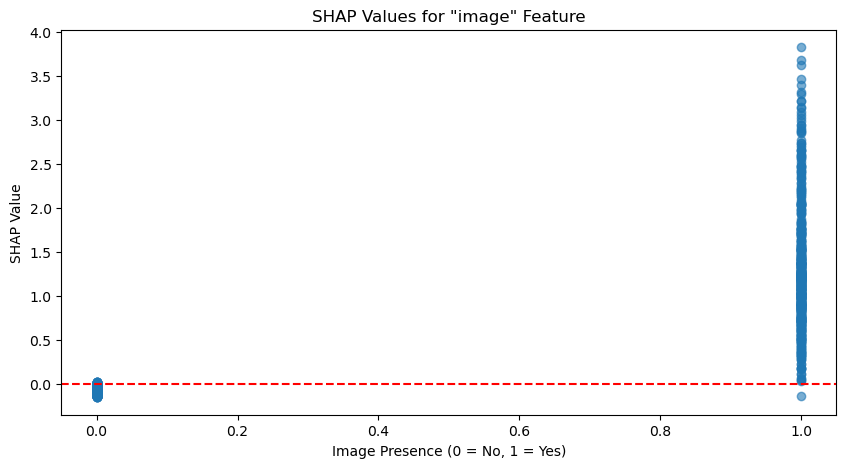

In [13]:
# Plot specifically for the 'image' feature
shap.dependence_plot('Image', shap_values, X_train)

# Extract SHAP values for the 'image' feature
image_shap_values = shap_values[:, X_train.columns.get_loc('Image')]

# Plot SHAP values for 'image'
plt.figure(figsize=(10, 5))
plt.scatter(X_train['Image'], image_shap_values, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('SHAP Values for "image" Feature')
plt.xlabel('Image Presence (0 = No, 1 = Yes)')
plt.ylabel('SHAP Value')
plt.show()


In [14]:
# Calculate the mean of the absolute SHAP values for each feature
average_shap_values_train = np.abs(shap_values).mean(axis=0)


In [15]:
# Create a DataFrame for the features and their average SHAP values
shap_df_train = pd.DataFrame({
    'features': X_train.columns,
    'average_shap_value': average_shap_values_train
})

# Sort the DataFrame based on the average SHAP values
shap_df_train_sorted = shap_df_train.sort_values(by='average_shap_value', ascending=False)

# Display the sorted DataFrame
print(shap_df_train_sorted)

      features  average_shap_value
7     ElapDays            0.874083
3        WordC            0.770438
0       RewExt            0.451320
2   Subjective            0.216100
5        SentL            0.170847
10       NounR            0.169034
13         FRE            0.162355
11        AdjR            0.155518
12        AdvR            0.137268
4        SentC            0.119588
8        Image            0.098667
9       VerPur            0.078334
1    Sentiment            0.061739
6       TitleL            0.041363


In [28]:
# Train model with SMOTE balanced data
xgb_cls_SMOTE = xgb.XGBClassifier()

xgb_cls_SMOTE.fit(X_train_balanced, y_train_balanced)

# Predictions on test data
y_pred_SMOTE = xgb_cls_SMOTE.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_SMOTE)
conf_matrix = confusion_matrix(y_test, y_pred_SMOTE)
cls_report = classification_report(y_test, y_pred_SMOTE)

print("\SMOTE Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_SMOTE)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_SMOTE)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_SMOTE, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)

\SMOTE Model Evaluation:
Accuracy: 0.867750677506775
F1 Score: 0.5579710144927537
AUC: 0.7192311884529443
Confusion Matrix:
[[1447   87]
 [ 157  154]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1534
           1       0.64      0.50      0.56       311

    accuracy                           0.87      1845
   macro avg       0.77      0.72      0.74      1845
weighted avg       0.86      0.87      0.86      1845

Mean Cross-Validated Accuracy: 0.8044861182035214


# 3. Hyperparameter tuning

In [31]:
# import packages for hyperparameters tuning with hyperopt (Bayesian Optimization)

# Define Search Space for hyperparameters
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={'max_depth': hp.quniform("max_depth", 3, 20, 1),
        'gamma': hp.uniform ('gamma', 0,5),
        'reg_lambda' : hp.uniform('reg_lambda', 0,10),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.3,1),
        'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
        'seed': 0
    }

# Define the objective function, objective function: Takes space as input (hyperparameters to optimize). Returns loss to minimize
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =int(space['n_estimators']), 
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_lambda = int(space['reg_lambda']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train_balanced, y_train_balanced), ( X_test, y_test)]
    
    clf.fit(X_train_balanced, y_train_balanced,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [32]:
# Running Bayesian Optimization

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                 
0.8525745257452575                                     
  1%|          | 1/100 [00:00<00:54,  1.83trial/s, best loss: -0.8525745257452575]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8444444444444444                                                                
  2%|▏         | 2/100 [00:00<00:44,  2.21trial/s, best loss: -0.8525745257452575]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8520325203252033                                                                
  3%|▎         | 3/100 [00:01<00:53,  1.81trial/s, best loss: -0.8525745257452575]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.846070460704607                                                                 
  4%|▍         | 4/100 [00:01<00:46,  2.06trial/s, best loss: -0.8525745257452575]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8482384823848238                                                                
  5%|▌         | 5/100 [00:02<00:42,  2.25trial/s, best loss: -0.8525745257452575]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8455284552845529                                                                
  6%|▌         | 6/100 [00:02<00:39,  2.38trial/s, best loss: -0.8525745257452575]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8482384823848238                                                                
  7%|▋         | 7/100 [00:03<00:46,  1.99trial/s, best loss: -0.8525745257452575]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8449864498644987                                                                
  8%|▊         | 8/100 [00:03<00:45,  2.01trial/s, best loss: -0.8525745257452575]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8509485094850948                                                                
  9%|▉         | 9/100 [00:04<00:50,  1.81trial/s, best loss: -0.8525745257452575]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8509485094850948                                                                
 10%|█         | 10/100 [00:05<00:49,  1.80trial/s, best loss: -0.8525745257452575]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.848780487804878                                                                  
 11%|█         | 11/100 [00:05<00:49,  1.81trial/s, best loss: -0.8525745257452575]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.846070460704607                                                                  
 12%|█▏        | 12/100 [00:06<00:48,  1.80trial/s, best loss: -0.8525745257452575]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8498644986449865                                                                 
 13%|█▎        | 13/100 [00:06<00:47,  1.84trial/s, best loss: -0.8525745257452575]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8520325203252033                                                                 
SCORE:                                                                             
0.8292682926829268                                                                 
 15%|█▌        | 15/100 [00:07<00:37,  2.30trial/s, best loss: -0.8525745257452575]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.848780487804878                                                                  
 16%|█▌        | 16/100 [00:07<00:38,  2.19trial/s, best loss: -0.8525745257452575]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8466124661246612                                                                 
 17%|█▋        | 17/100 [00:08<00:36,  2.26trial/s, best loss: -0.8525745257452575]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8428184281842819                                                                 
 18%|█▊        | 18/100 [00:08<00:36,  2.23trial/s, best loss: -0.8525745257452575]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8444444444444444                                                                 
 19%|█▉        | 19/100 [00:09<00:35,  2.26trial/s, best loss: -0.8525745257452575]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.832520325203252                                                                  
 20%|██        | 20/100 [00:09<00:31,  2.51trial/s, best loss: -0.8525745257452575]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8476964769647697                                                                 
 21%|██        | 21/100 [00:10<00:33,  2.39trial/s, best loss: -0.8525745257452575]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8504065040650407                                                                 
 22%|██▏       | 22/100 [00:10<00:34,  2.24trial/s, best loss: -0.8525745257452575]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8547425474254743                                                                 
 23%|██▎       | 23/100 [00:11<00:40,  1.90trial/s, best loss: -0.8547425474254743]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8536585365853658                                                                 
 24%|██▍       | 24/100 [00:11<00:39,  1.93trial/s, best loss: -0.8547425474254743]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8569105691056911                                                                 
 25%|██▌       | 25/100 [00:12<00:39,  1.90trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8476964769647697                                                                 
 26%|██▌       | 26/100 [00:12<00:39,  1.88trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8558265582655826                                                                 
 27%|██▋       | 27/100 [00:13<00:39,  1.86trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8552845528455284                                                                 
 28%|██▊       | 28/100 [00:13<00:38,  1.85trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8547425474254743                                                                 
 29%|██▉       | 29/100 [00:14<00:40,  1.74trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8466124661246612                                                                 
 30%|███       | 30/100 [00:15<00:37,  1.85trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8498644986449865                                                                 
 31%|███       | 31/100 [00:15<00:37,  1.82trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.848780487804878                                                                  
 32%|███▏      | 32/100 [00:16<00:33,  2.01trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8482384823848238                                                                 
 33%|███▎      | 33/100 [00:16<00:34,  1.97trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8498644986449865                                                                 
 34%|███▍      | 34/100 [00:17<00:36,  1.82trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8509485094850948                                                                 
 35%|███▌      | 35/100 [00:17<00:38,  1.67trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8542005420054201                                                                 
 36%|███▌      | 36/100 [00:18<00:36,  1.75trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8498644986449865                                                                 
 37%|███▋      | 37/100 [00:18<00:32,  1.91trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8493224932249323                                                                 
 38%|███▊      | 38/100 [00:19<00:32,  1.89trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8476964769647697                                                                 
 39%|███▉      | 39/100 [00:20<00:34,  1.79trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8504065040650407                                                                 
 40%|████      | 40/100 [00:20<00:35,  1.69trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8509485094850948                                                                 
 41%|████      | 41/100 [00:21<00:34,  1.71trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8476964769647697                                                                 
 42%|████▏     | 42/100 [00:21<00:32,  1.80trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.848780487804878                                                                  
 43%|████▎     | 43/100 [00:22<00:33,  1.71trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8482384823848238                                                                 
 44%|████▍     | 44/100 [00:22<00:32,  1.74trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8525745257452575                                                                 
 45%|████▌     | 45/100 [00:23<00:31,  1.76trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.851490514905149                                                                  
 46%|████▌     | 46/100 [00:24<00:30,  1.79trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8520325203252033                                                                 
 47%|████▋     | 47/100 [00:24<00:29,  1.78trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8444444444444444                                                                 
 48%|████▊     | 48/100 [00:24<00:26,  1.97trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8509485094850948                                                                 
 49%|████▉     | 49/100 [00:25<00:26,  1.95trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8417344173441734                                                                 
 50%|█████     | 50/100 [00:25<00:24,  2.08trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.846070460704607                                                                  
 51%|█████     | 51/100 [00:26<00:26,  1.87trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8476964769647697                                                                 
 52%|█████▏    | 52/100 [00:27<00:24,  1.95trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8422764227642277                                                                 
 53%|█████▎    | 53/100 [00:27<00:21,  2.18trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8509485094850948                                                                 
 54%|█████▍    | 54/100 [00:27<00:22,  2.09trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8504065040650407                                                                 
 55%|█████▌    | 55/100 [00:28<00:24,  1.84trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8525745257452575                                                                 
 56%|█████▌    | 56/100 [00:29<00:24,  1.80trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8493224932249323                                                                 
 57%|█████▋    | 57/100 [00:29<00:21,  2.00trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8493224932249323                                                                 
 58%|█████▊    | 58/100 [00:30<00:21,  1.98trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8493224932249323                                                                 
 59%|█████▉    | 59/100 [00:30<00:22,  1.81trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8525745257452575                                                                 
 60%|██████    | 60/100 [00:31<00:21,  1.90trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.848780487804878                                                                  
 61%|██████    | 61/100 [00:31<00:20,  1.88trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8476964769647697                                                                 
 62%|██████▏   | 62/100 [00:32<00:21,  1.79trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8455284552845529                                                                 
 63%|██████▎   | 63/100 [00:32<00:20,  1.77trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8476964769647697                                                                 
 64%|██████▍   | 64/100 [00:33<00:19,  1.81trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8471544715447155                                                                 
 65%|██████▌   | 65/100 [00:33<00:18,  1.88trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.848780487804878                                                                  
 66%|██████▌   | 66/100 [00:34<00:17,  1.94trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8547425474254743                                                                 
 67%|██████▋   | 67/100 [00:35<00:18,  1.77trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8476964769647697                                                                 
 68%|██████▊   | 68/100 [00:35<00:17,  1.84trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8482384823848238                                                                 
 69%|██████▉   | 69/100 [00:35<00:15,  2.00trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8531165311653116                                                                 
 70%|███████   | 70/100 [00:36<00:15,  1.90trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.846070460704607                                                                  
 71%|███████   | 71/100 [00:37<00:17,  1.70trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8476964769647697                                                                 
 72%|███████▏  | 72/100 [00:37<00:15,  1.80trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8449864498644987                                                                 
 73%|███████▎  | 73/100 [00:38<00:13,  1.97trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8525745257452575                                                                 
 74%|███████▍  | 74/100 [00:38<00:15,  1.71trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8520325203252033                                                                 
 75%|███████▌  | 75/100 [00:39<00:14,  1.69trial/s, best loss: -0.8569105691056911]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8596205962059621                                                                 
 76%|███████▌  | 76/100 [00:40<00:14,  1.68trial/s, best loss: -0.8596205962059621]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8509485094850948                                                                 
 77%|███████▋  | 77/100 [00:40<00:14,  1.59trial/s, best loss: -0.8596205962059621]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8525745257452575                                                                 
 78%|███████▊  | 78/100 [00:41<00:13,  1.68trial/s, best loss: -0.8596205962059621]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8542005420054201                                                                 
 79%|███████▉  | 79/100 [00:41<00:11,  1.75trial/s, best loss: -0.8596205962059621]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.851490514905149                                                                  
 80%|████████  | 80/100 [00:42<00:11,  1.80trial/s, best loss: -0.8596205962059621]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8590785907859079                                                                 
 81%|████████  | 81/100 [00:43<00:12,  1.56trial/s, best loss: -0.8596205962059621]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8504065040650407                                                                 
 82%|████████▏ | 82/100 [00:43<00:11,  1.62trial/s, best loss: -0.8596205962059621]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8525745257452575                                                                 
 83%|████████▎ | 83/100 [00:44<00:09,  1.73trial/s, best loss: -0.8596205962059621]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.851490514905149                                                                  
 84%|████████▍ | 84/100 [00:44<00:08,  1.81trial/s, best loss: -0.8596205962059621]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8482384823848238                                                                 
 85%|████████▌ | 85/100 [00:45<00:08,  1.68trial/s, best loss: -0.8596205962059621]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8493224932249323                                                                 
 86%|████████▌ | 86/100 [00:46<00:07,  1.76trial/s, best loss: -0.8596205962059621]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.848780487804878                                                                  
 87%|████████▋ | 87/100 [00:46<00:07,  1.71trial/s, best loss: -0.8596205962059621]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.851490514905149                                                                  
 88%|████████▊ | 88/100 [00:47<00:07,  1.60trial/s, best loss: -0.8596205962059621]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.851490514905149                                                                  
 89%|████████▉ | 89/100 [00:47<00:06,  1.63trial/s, best loss: -0.8596205962059621]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8493224932249323                                                                 
 90%|█████████ | 90/100 [00:48<00:07,  1.42trial/s, best loss: -0.8596205962059621]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8504065040650407                                                                 
 91%|█████████ | 91/100 [00:49<00:06,  1.44trial/s, best loss: -0.8596205962059621]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8384823848238483                                                                 
 92%|█████████▏| 92/100 [00:49<00:04,  1.64trial/s, best loss: -0.8596205962059621]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8520325203252033                                                                 
 93%|█████████▎| 93/100 [00:50<00:04,  1.55trial/s, best loss: -0.8596205962059621]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.848780487804878                                                                  
 94%|█████████▍| 94/100 [00:51<00:04,  1.41trial/s, best loss: -0.8596205962059621]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8422764227642277                                                                 
 95%|█████████▌| 95/100 [00:51<00:03,  1.66trial/s, best loss: -0.8596205962059621]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.848780487804878                                                                  
 96%|█████████▌| 96/100 [00:52<00:02,  1.57trial/s, best loss: -0.8596205962059621]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8509485094850948                                                                 
 97%|█████████▋| 97/100 [00:53<00:01,  1.51trial/s, best loss: -0.8596205962059621]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8525745257452575                                                                 
 98%|█████████▊| 98/100 [00:54<00:01,  1.42trial/s, best loss: -0.8596205962059621]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.848780487804878                                                                  
 99%|█████████▉| 99/100 [00:54<00:00,  1.37trial/s, best loss: -0.8596205962059621]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8547425474254743                                                                 
100%|██████████| 100/100 [00:55<00:00,  1.79trial/s, best loss: -0.8596205962059621]
The best hyperparameters are :  

{'colsample_bytree': 0.4315344738382495, 'gamma': 4.135489032914681, 'max_depth': 10.0, 'min_child_weight': 2.0, 'n_estimators': 150.0, 'reg_lambda': 2.3845317175205962}


In [42]:
best_hyperparams={'colsample_bytree': 0.4315344738382495, 'gamma': 4.135489032914681, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 150, 'reg_lambda': 2.3845317175205962}


In [43]:
# With considering inbalanced data
from collections import Counter
sqrt = np.sqrt

# Assuming y_train is your ndarray
counts = y_train_balanced.value_counts()

# counts[0] will give you the count of 0s
# counts[1] will give you the count of 1s
count_of_zeros = counts[0]
count_of_ones = counts[1]

# Calculate scale_pos_weight
weight_ratio = int(sqrt(count_of_zeros /count_of_ones))

print("Class distribution in the training set:", counts)
print("scale_pos_weight:", weight_ratio)

Class distribution in the training set: helpful
0    13808
1     8000
Name: count, dtype: int64
scale_pos_weight: 1


In [44]:
# Train model with default hyperparameters
xgb_cls_hyp = xgb.XGBClassifier(**best_hyperparams, scale_pos_weight=weight_ratio)

xgb_cls_hyp.fit(X_train_balanced, y_train_balanced)

# Predictions on test data
y_pred_opt = xgb_cls_hyp.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_opt)
conf_matrix = confusion_matrix(y_test, y_pred_opt)
cls_report = classification_report(y_test, y_pred_opt)

print("\nSMOTE-Hyp Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_opt)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_opt)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_hyp, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)


SMOTE-Hyp Model Evaluation:
Accuracy: 0.8644986449864499
F1 Score: 0.558303886925795
AUC: 0.7224026042081523
Confusion Matrix:
[[1437   97]
 [ 153  158]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1534
           1       0.62      0.51      0.56       311

    accuracy                           0.86      1845
   macro avg       0.76      0.72      0.74      1845
weighted avg       0.86      0.86      0.86      1845

Mean Cross-Validated Accuracy: 0.7991202397222432


[15:30:08] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


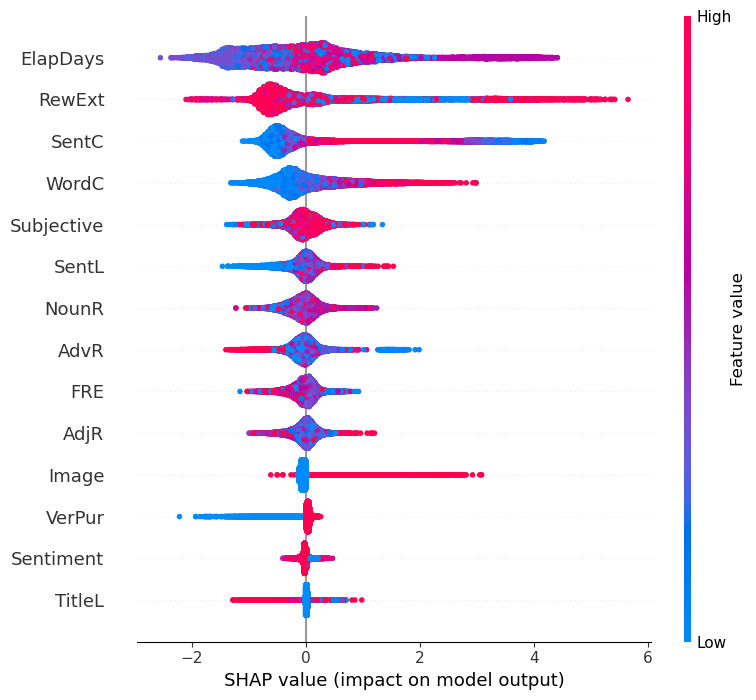

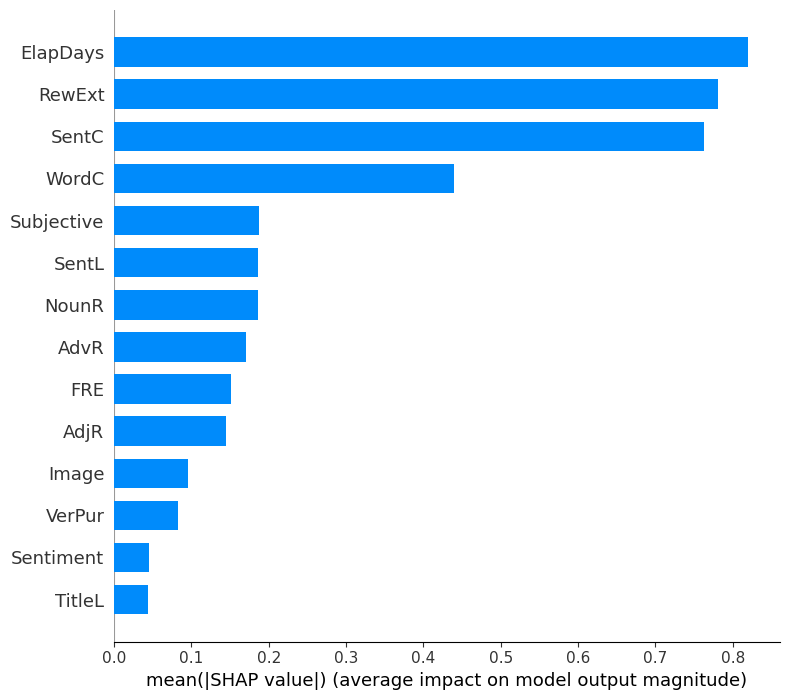

In [45]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_cls_SMOTE)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train_balanced)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train_balanced)

# Create a beeswarm plot
shap.summary_plot(shap_values, X_train_balanced, plot_type="bar", show=False)
plt.show()


[15:30:23] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
100%|===================| 21769/21808 [01:25<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


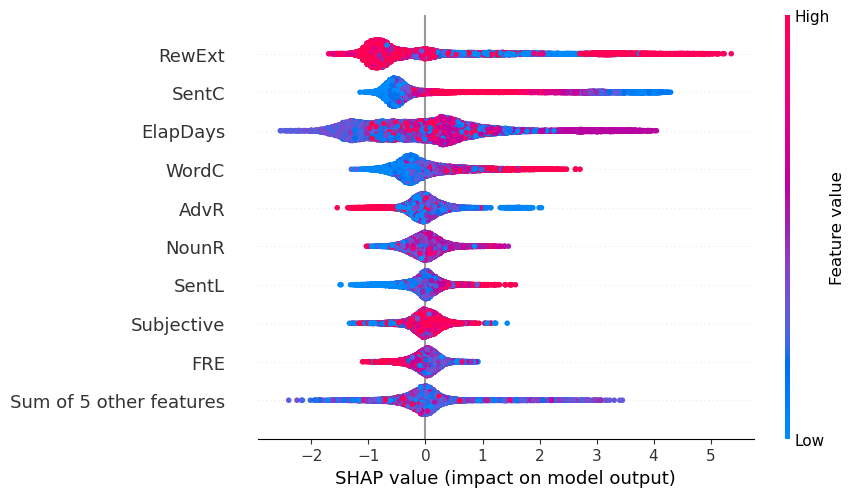

In [46]:
# compute SHAP values
explainer = shap.Explainer(xgb_cls_SMOTE, X_train_balanced)
shap_values = explainer(X_train_balanced)

shap.plots.beeswarm(shap_values, max_display=12)


[15:31:54] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


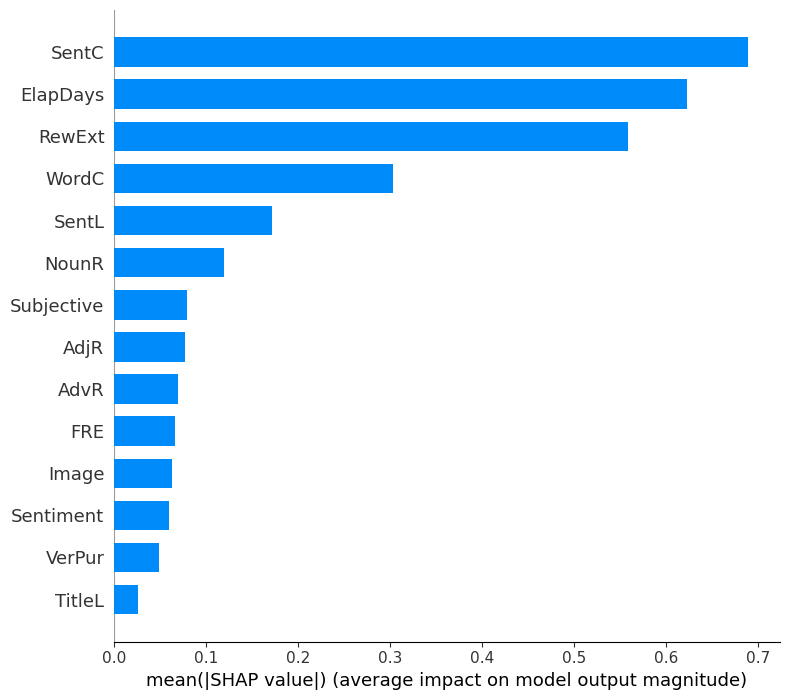

In [47]:
import matplotlib.pyplot as plt
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_cls_hyp)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train_balanced)

# Plot the SHAP summary plot with beeswarm plot
shap.summary_plot(shap_values, X_train_balanced, plot_type="bar", show=True)


[15:31:57] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 97%|=================== | 21145/21808 [00:31<00:00]       No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


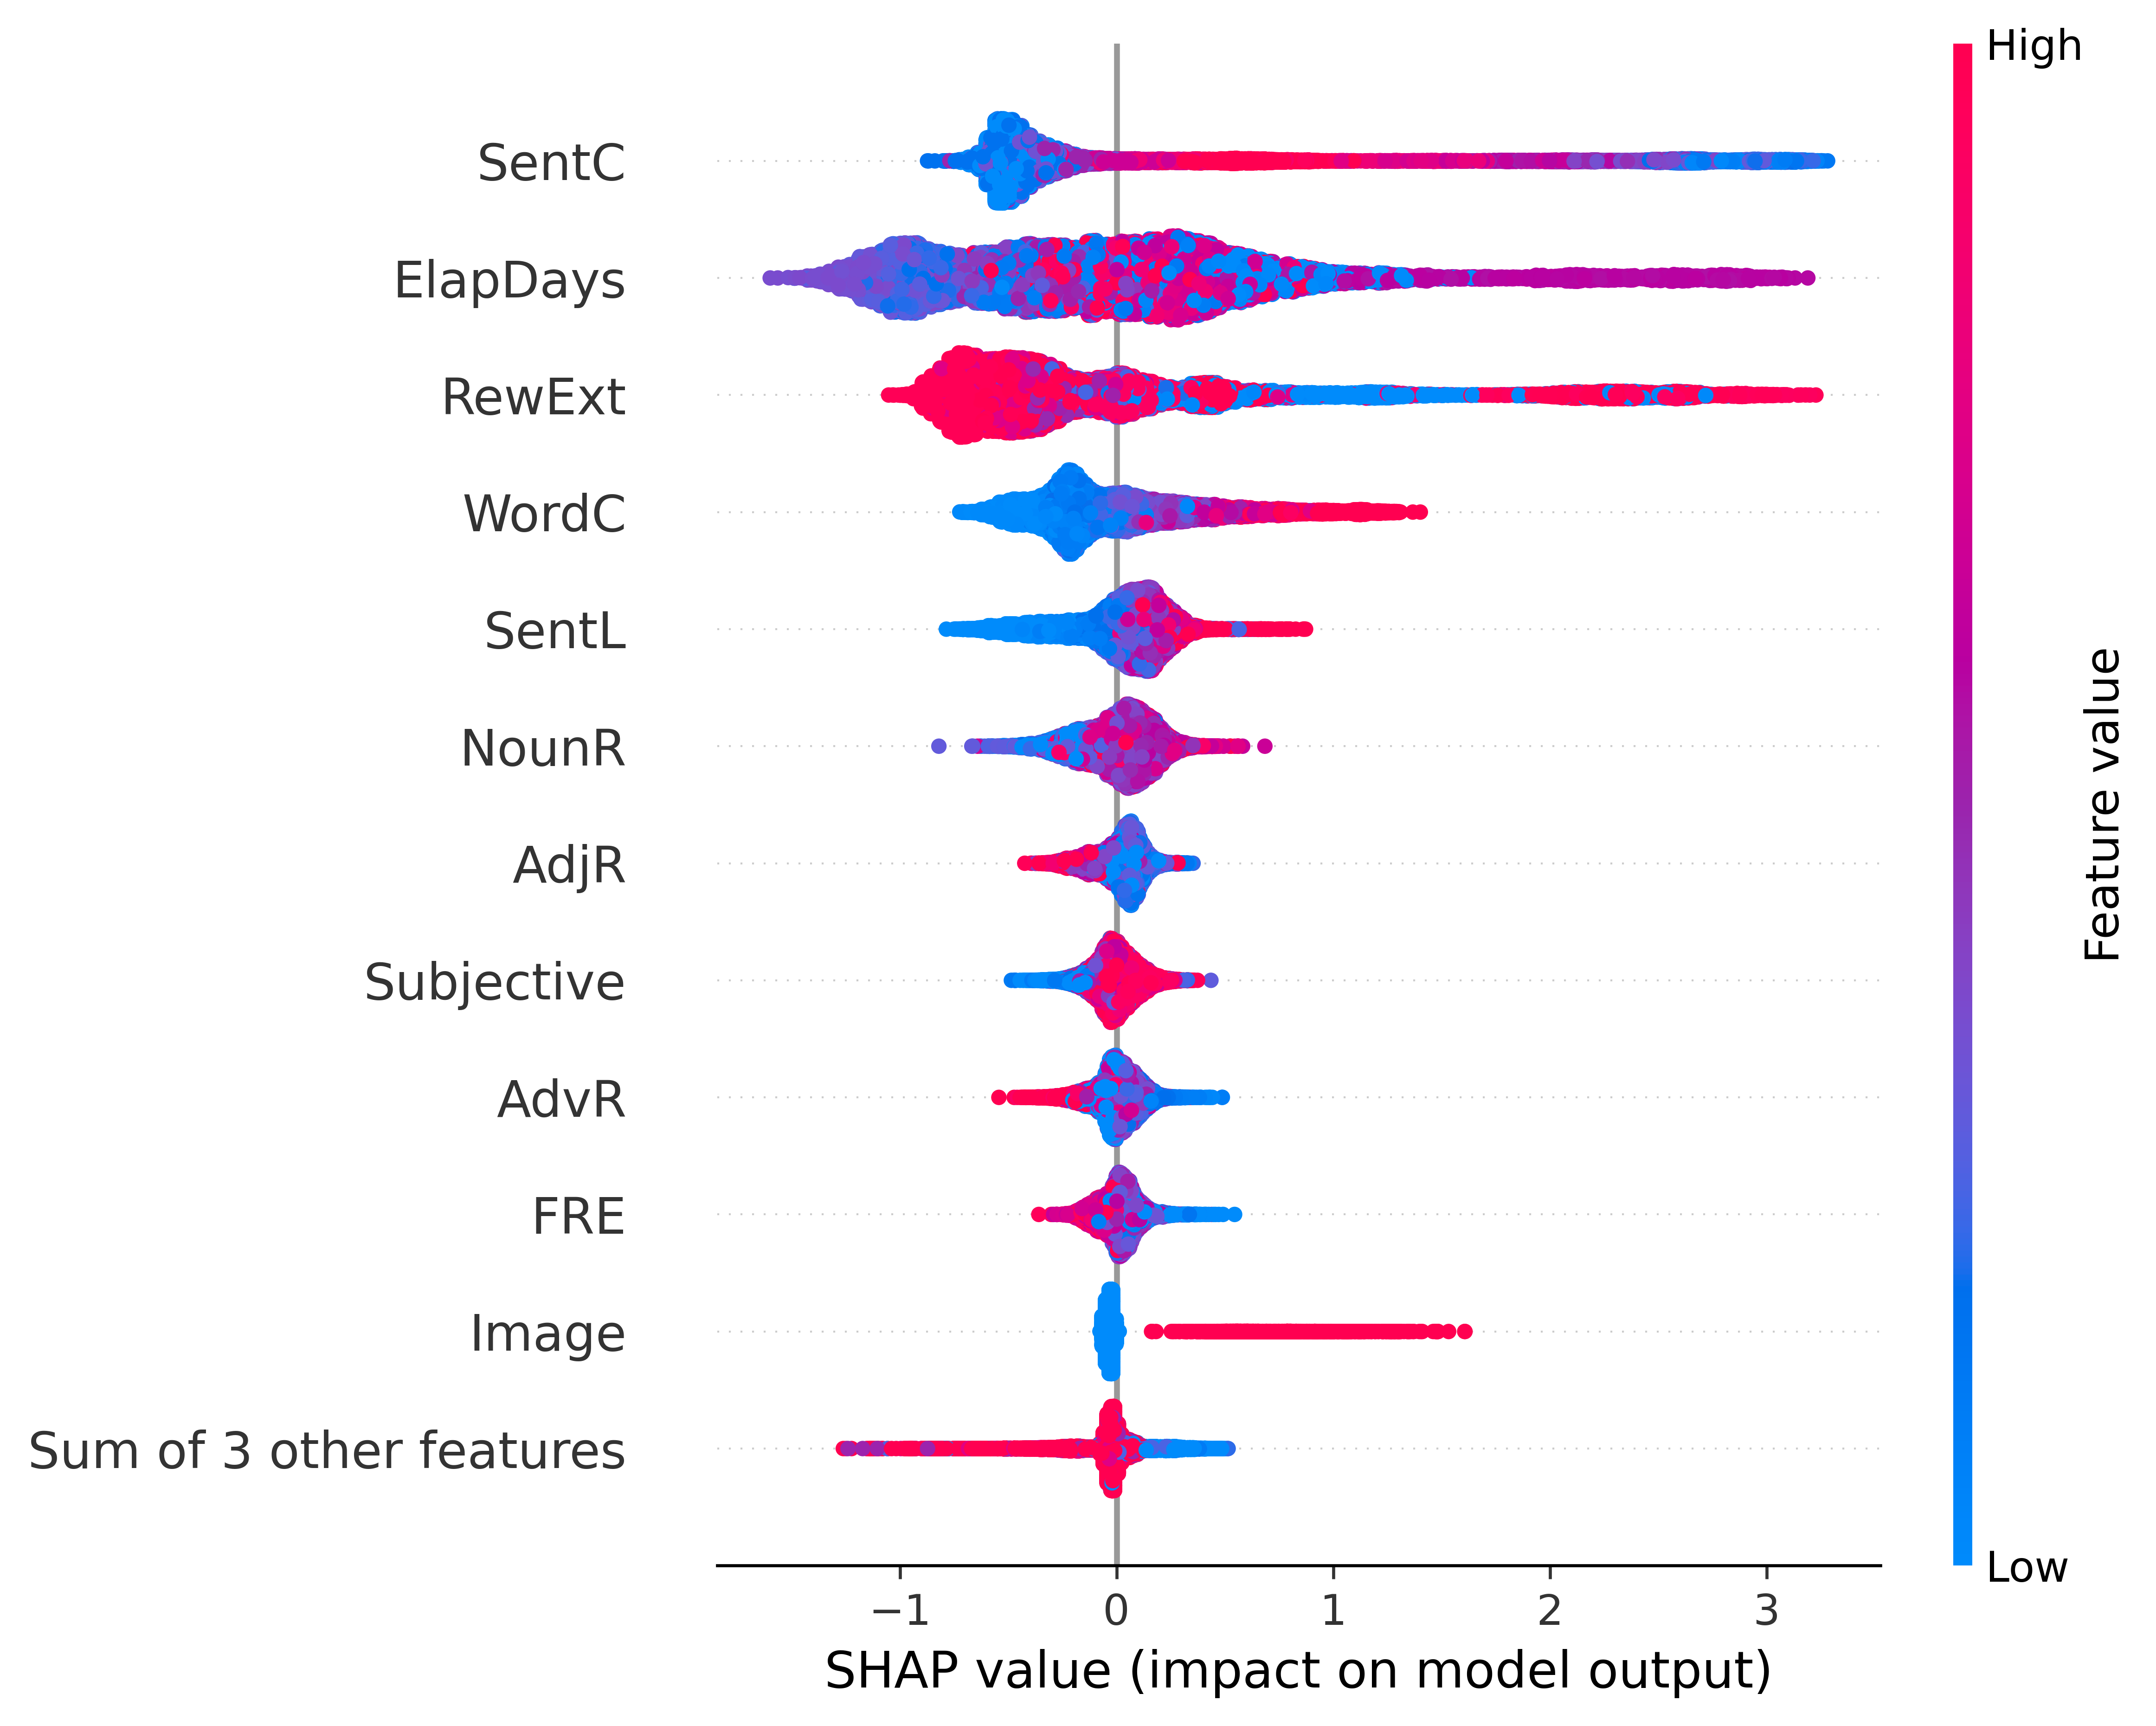

In [48]:
import shap
import matplotlib.pyplot as plt

# Compute SHAP values
explainer = shap.TreeExplainer(xgb_cls_hyp, X_train_balanced)
shap_values = explainer(X_train_balanced)

# Create a beeswarm plot with increased quality
fig, ax = plt.subplots(figsize=(12, 8), dpi=600)  # Set figure size and DPI
shap.plots.beeswarm(shap_values, max_display=12, show=False)  # Create the plot without displaying it immediately
plt.tight_layout()  # Adjust the layout to prevent clipping

# Save the plot to a file with high resolution
plt.savefig('shap_beeswarm_plot_Hedonic.png', dpi=600)  # Save the figure with the desired DPI

# Display the plot
plt.show()
